In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import os, sys, pathlib, h5py, time

from models import make_model

import pickle as pk

from astropy.nddata import block_reduce

from matplotlib import pyplot as plt

from astropy.io import fits

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-12-05 16:06:41.844581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31016 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2022-12-05 16:06:41.847171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2022-12-05 16:06:41.849574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2022-12-05 16:06:41.851976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

# Load and perform some cuts on data

In [24]:
data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']


In [25]:
stamps.shape

(4195, 41, 41, 3)

In [26]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

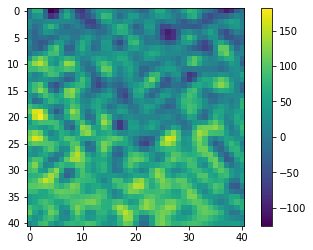

In [29]:
plt.imshow(stamps[50,...,0])
plt.colorbar()

In [31]:
stamps /= 300

In [32]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal']

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# A simple Dense Model

In [52]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 5043)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                322816    
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 327,041
Trainable params: 327,041
Non-trainable params: 0
_________________________________________________________________


In [54]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)




Epoch 1/50
6/6 [==============================] - 1s 42ms/step - loss: 2.1290 - val_loss: 1.2636
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0758 - val_loss: 1.0853
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.8692 - val_loss: 1.1297
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.7232 - val_loss: 0.9943
Epoch 5/50
6/6 [==============================] - 0s 23ms/step - loss: 0.6428 - val_loss: 0.9955
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.6350 - val_loss: 1.0176
Epoch 7/50
6/6 [==============================] - 0s 23ms/step - loss: 0.5879 - val_loss: 1.0797
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 0.5684 - val_loss: 0.9812
Epoch 9/50
6/6 [==============================] - 0s 24ms/step - loss: 0.5025 - val_loss: 1.0069
Epoch 10/50
6/6 [==============================] - 0s 22ms/step - loss: 0.4503 - val_loss: 1.0037
Epoch 11/50
6/6 [============

In [55]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])
#It does shit

[-1.322206]
[-4.1848288]
[0.62935257]
[-1.5596745]
[-0.9097085]
[-2.0816574]
[-7.2058144]
[0.2578566]
[1.8290396]
[-5.819723]
[0.09744024]
[-2.5317466]
[-0.79503274]
[0.76748323]
[1.2818494]
[-0.5636425]
[-0.73969793]
[0.26605558]
[0.42869115]
[-0.4438734]
[-0.04729819]
[-0.05511546]
[5.629614]
[-0.17271757]
[-2.7422109]
[2.0656886]
[-0.04578567]
[0.01168871]
[3.7524602]
[0.6338148]
[-2.6980171]
[1.6342628]
[-1.0446422]
[-2.5664685]
[0.4532194]
[-0.01426482]
[2.643563]
[-0.21050858]
[-0.5266087]
[-0.42185497]
[2.1604018]
[-0.7545538]
[0.51746583]
[-0.36840558]
[0.2689941]
[-2.9526591]
[-0.9209652]
[-1.187269]
[3.5167344]
[-0.26876974]
[1.5624397]
[0.09751749]
[-0.49260902]
[0.46579313]
[-0.01437378]
[0.28501725]
[-0.5516205]
[-0.30986452]
[-8.576283]
[-1.455832]
[-3.5819361]
[2.2401173]
[0.13022041]
[1.4675786]
[-1.3272288]
[-1.6913655]
[5.266282]
[-0.20435]
[0.16095781]
[0.5388055]
[-1.4406161]
[-0.75655866]
[0.21480632]
[2.2076998]
[-0.06651735]
[-1.9713862]
[-0.1962421]
[-1.2290521]

[0.16777611]
[0.11116409]
[0.8576369]
[6.076137]
[4.1552033]
[1.0162232]
[-0.85947824]
[0.40429306]
[0.17306566]
[0.58384323]
[-4.795512]
[-3.4665961]
[0.5508342]
[-0.06585741]
[0.29432797]
[-0.82868457]
[-0.5363462]
[1.9206531]
[5.1957293]
[2.3166957]
[2.7147062]
[0.0967586]
[-0.63895464]
[-2.173064]
[2.1285973]
[0.28227925]
[0.49567795]
[0.7330942]
[0.20447516]
[0.6084175]
[0.7313218]
[-0.81278896]
[-1.323236]
[-1.0934548]
[-0.55406666]
[2.4549558]
[-0.8142967]
[0.378119]
[0.64066577]
[1.0519466]
[-0.30157185]
[-1.1775756]
[1.5421348]
[-1.145236]
[1.0738957]
[-1.9593074]
[0.73048973]
[-0.5450394]
[-0.74257493]
[-0.61905956]
[-0.27230453]
[-0.33935094]
[0.39665794]
[-0.31826591]
[-6.8135834]
[-3.7679315]
[-5.332387]
[3.7163992]
[-0.20681858]
[1.1022072]
[-0.18240547]
[0.15366483]
[-0.37123346]
[1.7866654]
[0.87887955]
[-0.07040834]
[-3.463981]
[-1.3060813]
[0.09858227]
[0.26259875]
[-0.38127327]
[-1.4416752]
[0.54943967]
[0.06811094]
[2.2239819]
[2.7334971]
[-0.53772163]
[-0.9246609]


[-0.5621705]
[0.1444807]
[-0.08885193]
[-0.90181756]
[0.40858936]
[-0.0588119]
[0.9000032]
[0.3929901]
[2.1083846]
[0.15536237]
[-0.13328815]
[-2.7231357]
[0.57939744]
[1.1882522]
[0.21703649]
[1.2945673]
[-0.05131364]
[0.19786286]
[-1.4715712]
[-0.78230095]
[3.1786237]
[0.12220287]
[-2.6648645]
[-5.231811]
[0.02941251]
[0.5215843]
[1.8426752]
[0.9650328]
[0.9555521]
[0.35329223]
[-5.173972]
[2.0723016]
[-0.25925946]
[5.801266]
[-0.8969815]
[0.29925394]
[1.7506864]
[0.12661457]
[-0.25194216]
[-0.7263763]
[0.4575734]
[1.4874682]
[1.0444353]
[-2.4178755]
[-3.545973]
[-1.1340258]
[-0.05240011]
[-0.30144405]
[-2.8630388]
[-0.5351536]
[1.0819898]
[-0.09566784]
[-2.8047605]
[-5.5947385]
[-2.1287677]
[0.47428346]
[-0.35837483]
[-0.3033471]
[-1.2538354]
[0.84073424]
[-1.84028]
[0.19482112]
[0.12602687]
[0.4965732]
[-2.7032416]
[1.8896377]
[1.6534238]
[0.47615004]
[-1.9502704]
[0.793272]
[-0.14410734]
[-0.15169668]
[1.6008791]
[-0.25135446]
[-0.45233154]
[-1.0247791]
[2.6742067]
[-8.049738]
[0.

# CNN Model

In [56]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [57]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50


2022-12-02 17:14:48.153909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-12-02 17:15:06.995527: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996197: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996230: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-02 17:15:06.996813: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996877: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 35s 115ms/step - loss: 1.8759 - val_loss: 1.3473
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 1.1238 - val_loss: 0.9743
Epoch 3/50
6/6 [==============================] - 0s 29ms/step - loss: 1.0241 - val_loss: 1.0253
Epoch 4/50
6/6 [==============================] - 0s 28ms/step - loss: 0.9366 - val_loss: 1.0009
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.9197 - val_loss: 0.9164
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.8630 - val_loss: 0.9224
Epoch 7/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8142 - val_loss: 0.9000
Epoch 8/50
6/6 [==============================] - 0s 28ms/step - loss: 0.7948 - val_loss: 0.8958
Epoch 9/50
6/6 [==============================] - 0s 29ms/step - loss: 0.7981 - val_loss: 0.9261
Epoch 10/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8317 - val_loss: 0.8892
Epoch 11/50
6/6 [=====================

In [32]:
from tensorflow.keras import optimizers, layers, models, regularizers

model = tf.keras.models.Sequential([
layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape=input_shape),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.Dense(2)])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))



In [35]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
92/92 [==============================] - 3s 23ms/step - loss: 0.9632 - val_loss: 0.9910
Epoch 2/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8939 - val_loss: 0.9876
Epoch 3/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8773 - val_loss: 0.9375
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8628 - val_loss: 1.0255
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8110 - val_loss: 0.9692
Epoch 6/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8129 - val_loss: 0.9733
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7913 - val_loss: 0.9357
Epoch 8/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7803 - val_loss: 0.8934
Epoch 9/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7693 - val_loss: 0.8994
Epoch 10/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7721 - val_loss: 0.8937
Epoch 11/

## Ntampka Freqs

In [37]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2), strides = 2))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [38]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)

Epoch 1/50
92/92 [==============================] - 3s 24ms/step - loss: 2.3089 - val_loss: 1.0234
Epoch 2/50
92/92 [==============================] - 2s 23ms/step - loss: 1.0567 - val_loss: 0.7018
Epoch 3/50
92/92 [==============================] - 2s 23ms/step - loss: 0.9000 - val_loss: 0.9061
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8078 - val_loss: 0.5924
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7604 - val_loss: 0.5261
Epoch 6/50
92/92 [==============================] - 2s 23ms/step - loss: 0.6698 - val_loss: 0.4978
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.6945 - val_loss: 0.4486
Epoch 8/50
92/92 [==============================] - 2s 23ms/step - loss: 0.6680 - val_loss: 0.5177
Epoch 9/50
92/92 [==============================] - 2s 23ms/step - loss: 0.6235 - val_loss: 0.4497
Epoch 10/50
92/92 [==============================] - 2s 23ms/step - loss: 0.6653 - val_loss: 0.4496
Epoch 11/

In [39]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)

In [40]:
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.13101828
0.14401387


# Compton y

In [46]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

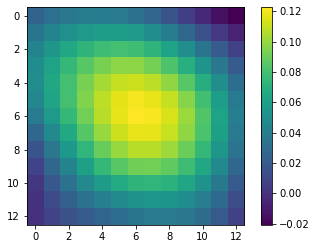

In [47]:
plt.imshow(stamps[50])
plt.colorbar()

In [48]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [49]:
factor = 2

stamps *= factor

In [50]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [55]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [56]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)


Epoch 1/50
6/6 [==============================] - 1s 34ms/step - loss: 3.5184 - val_loss: 3.2655
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 3.2043 - val_loss: 2.9547
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 2.8732 - val_loss: 2.5695
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 2.4489 - val_loss: 2.0659
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 1.8822 - val_loss: 1.3886
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 1.1453 - val_loss: 0.6503
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.5391 - val_loss: 0.6598
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.6397 - val_loss: 0.7156
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.5754 - val_loss: 0.5531
Epoch 10/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4914 - val_loss: 0.5192
Epoch 11/50
6/6 [============

In [57]:
predictions = model.predict(train_dataset)

errs = []
for i in range(len(train_labels)):
    errs.append((train_labels[i]-predictions[i])/predictions[i])

In [58]:
np.mean(np.abs(errs))

0.3689581

# Compton-y CNN

In [3]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

In [4]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [5]:
factor = 2
stamps *=factor

In [6]:
stamps = np.expand_dims(stamps, axis=-1)


In [7]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 100
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [123]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [124]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
6/6 [==============================] - 1s 38ms/step - loss: 8.7106 - val_loss: 0.4624
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 1.7310 - val_loss: 1.4153
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.6642 - val_loss: 0.7713
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.8035 - val_loss: 0.4639
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.3226 - val_loss: 0.5732
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.4164 - val_loss: 0.3302
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.2680 - val_loss: 0.3276
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.2487 - val_loss: 0.2646
Epoch 9/50
6/6 [==============================] - 0s 20ms/step - loss: 0.2136 - val_loss: 0.2592
Epoch 10/50
6/6 [==============================] - 0s 19ms/step - loss: 0.1945 - val_loss: 0.2279
Epoch 11/50
6/6 [============

In [131]:
comp = test_dataset

predictions = model.predict(comp)



errs = []
for i in range(len(comp)):
    errs.append((comp[i]-predictions[i])/predictions[i])

In [132]:
np.mean(np.abs(errs))

0.37266538

## Ntampaka

In [8]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2), strides = 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [9]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50


2022-12-05 16:07:26.044900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-12-05 16:07:26.454254: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-05 16:07:26.454842: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-05 16:07:26.454869: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-05 16:07:26.455432: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-05 16:07:26.455482: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


30/30 [==============================] - 2s 14ms/step - loss: 3.4565 - val_loss: 0.5492
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1796 - val_loss: 0.1955
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1294 - val_loss: 0.2067
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1147 - val_loss: 0.1681
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1076 - val_loss: 0.1605
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1046 - val_loss: 0.1524
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0940 - val_loss: 0.1579
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1003 - val_loss: 0.1390
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0978 - val_loss: 0.1576
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0848 - val_loss: 0.1326
Epoch 11/50
30/30 [==========

In [10]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)
        
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.07291223
0.063318625


In [203]:


data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)

Epoch 1/50
92/92 [==============================] - 2s 14ms/step - loss: 0.2221 - val_loss: 0.1426
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1434 - val_loss: 0.1479
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1315 - val_loss: 0.2901
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1538 - val_loss: 0.1509
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1415 - val_loss: 0.1995
Epoch 6/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1329 - val_loss: 0.2254
Epoch 7/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1122 - val_loss: 0.1455
Epoch 8/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1472 - val_loss: 0.9802
Epoch 9/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1450 - val_loss: 0.1447
Epoch 10/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1157 - val_loss: 0.1344
Epoch 11/

In [224]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)

In [226]:
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.055931102
0.06512552
